# A/B testing: A step-by-step guide in Python

In [ ]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number

print(required_n)

4720


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aaubs/data_science_master/main/data/ab_data.csv')

df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [ ]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965

In [ ]:
df = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')

In [ ]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0

In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 1 users that appear multiple times in the dataset


In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 290583 entries


In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [ ]:
ab_test

user_id                   timestamp      group landing_page  converted
0      864622  2017-01-07 19:35:55.115584    control     old_page          0
1      931017  2017-01-20 22:24:11.980654    control     old_page          0
2      822759  2017-01-10 19:00:45.471182    control     old_page          0
3      715765  2017-01-19 23:16:23.269389    control     old_page          0
4      666686  2017-01-23 00:08:30.152180    control     old_page          0
...       ...                         ...        ...          ...        ...
9435   688017  2017-01-12 11:50:30.520706  treatment     new_page          0
9436   793361  2017-01-15 17:14:40.878898  treatment     new_page          0
9437   643157  2017-01-04 02:55:40.819424  treatment     new_page          0
9438   695345  2017-01-13 20:57:14.879484  treatment     new_page          0
9439   896118  2017-01-06 12:39:53.472660  treatment     new_page          0

[9440 rows x 5 columns]

In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

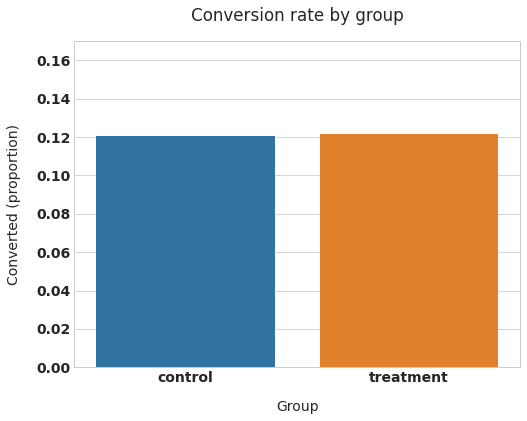

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.16
p-value: 0.875
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.112, 0.131]
